**Notebook summary:** This notebook contains the data processing steps required for the specification of the demand specific distribution in the OEO database. It draws on the EFS hourly load profiles dataset and uses hourly heating degree and cooling degree day data to separate the combined profiles published in EFS.

# Essentials

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import urllib.request
import os
import seaborn as sns
import gzip
from pandas.api.types import CategoricalDtype
# from plotnine import *
import zipfile
from matplotlib.pyplot import figure
import matplotlib.backends.backend_pdf
import matplotlib.patches as mpatches
# sns.set()
sns.set(style='white', font_scale=1.2)

In [2]:
region_names = dict()
region_names[1] = 'CA'
region_names[2] = 'NW'
region_names[3] = 'SW'
region_names[4] = 'TX'
region_names[5] = 'CEN'
region_names[6] = 'N_CEN'
region_names[7] = 'SE'
region_names[8] = 'MID_AT'
region_names[9] = 'NE'

In [3]:
demand_name_map = dict()
demand_name_map['CSH'] = 'Commercial Space Heating'
demand_name_map['CSC'] = 'Commercial Space Cooling'
demand_name_map['RSH'] = 'Residential Space Heating'
demand_name_map['RSC'] = 'Residential Space Cooling'

In [2]:
# hours in each month
monthly_hours = [31*24, 28*24, 31*24, 30*24, 31*24, 30*24, 31*24, 31*24, 30*24, 31*24, 30*24, 31*24]

# function which output cumulative sum of a numeric list
def func_cumulative_list(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

In [5]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Heating Degree Day and Cooling Degree Day for OEO regions

##  Hourly HDD and CDD Data from IPM Regions

In [6]:
df_hourly_DD_raw = pd.read_csv('./rawData/IPM2010.csv')
df_IPM_OEO_map = pd.read_csv('./rawData/IPM_regions_cluster.csv')

In [7]:
df_hourly_DD = df_hourly_DD_raw[['Region', 'date_time', 'temp', 'hdh',
                                 'cdh']].copy()
df_hourly_DD['hour_ID'] = [
    j + 1 for i in range(len(df_hourly_DD['Region'].unique()))
    for j in range(8760)
]
df_hourly_DD = df_hourly_DD.merge(df_IPM_OEO_map,
                                  left_on='Region',
                                  right_on='IPM_REGION')
df_hourly_DD.drop(columns=['Region', 'IPM_REGION', 'temp', 'date_time'],
                  inplace=True)
df_hourly_DD['OEO_REGION'] = df_hourly_DD['OEO_REGION'].map(region_names)
# average hdh and cdh fraction for a certain region
df_hourlyDD_grouped = df_hourly_DD.groupby(['OEO_REGION', 'hour_ID'
                                            ])[['hdh',
                                                'cdh']].mean().reset_index()
df_hourlyDD_grouped['hdh_frac'] = df_hourlyDD_grouped['hdh'] / (
    df_hourlyDD_grouped['hdh'] + df_hourlyDD_grouped['cdh'])
df_hourlyDD_grouped['cdh_frac'] = df_hourlyDD_grouped['cdh'] / (
    df_hourlyDD_grouped['hdh'] + df_hourlyDD_grouped['cdh'])
df_hourlyDD_grouped.drop(columns=['hdh', 'cdh'], inplace=True)
# sum of averages or average of sums?
# df_hourly_DD['hdh_frac'] = df_hourly_DD['hdh'] / (df_hourly_DD['hdh'] + df_hourly_DD['cdh'])
# df_hourly_DD['cdh_frac'] = df_hourly_DD['cdh'] / (df_hourly_DD['hdh'] + df_hourly_DD['cdh'])
# # average hdh and cdh fraction for a certain region
# df_hourlyDD_grouped = df_hourly_DD.groupby(['OEO_REGION', 'hour_ID'])[['hdh_frac', 'cdh_frac']].mean().reset_index()

## Monthly HDD and CDD data

In [5]:
# We use hourly HDD/CDD data but there is the option of using monthly HDD/CDD data if desired

In [8]:
df_monthly_dd_raw = pd.read_csv('./rawData/HDD_CDD_fracs.csv')
df_monthly_dd_raw

Date  Date_month  Region Region_OEO  HDD_sum  HDD_count  CDD_sum  \
0    201201           1       1         CA      445          1        4   
1    201201           1       2         NW     5222          5        1   
2    201201           1       3         SW     4018          5        5   
3    201201           1       4         TX      387          1       31   
4    201201           1       5        CEN     5752          7       56   
..      ...         ...     ...        ...      ...        ...      ...   
103  201212          12       5        CEN     5799          7       25   
104  201212          12       6      N_CEN     8065          7        0   
105  201212          12       7         SE     3761          8      165   
106  201212          12       8     MID_AT     5335          7        0   
107  201212          12       9         NE     6891          7        0   

     HDD_frac  CDD_frac  
0    0.991091  0.008909  
1    0.999809  0.000191  
2    0.998757  0.001243  
3    0.925837  0.074163  
4    0.990358  0.009642  
..        ...       ...  
103  0.995707  0.004293  
104  1.000000  0.000000  
105  0.957972  0.042028  
106  1.000000  0.000000  
107  1.000000  0.000000  

[108 rows x 9 columns]

# Hourly EFS Demands

## EFS demand data munging

In [9]:
df_EFS_demands = pd.read_csv('./rawData/EFSLoadProfile_High_Rapid.zip')
df_state_groupings = pd.read_csv('./rawData/state_regions_cluster.csv', index_col=0)

In [10]:
# Subset buildings data under the high rapid tech advancement scenario
df_EFS_demands_temp = df_EFS_demands.loc[
    (df_EFS_demands['Sector'] == 'Commercial') |
    (df_EFS_demands['Sector'] == 'Residential')].copy()
df_EFS_demands_temp.drop(columns=['Electrification', 'TechnologyAdvancement'],
                         inplace=True)
# subsectors represented:
df_EFS_demands_temp[['Sector', 'Subsector']].drop_duplicates()

Sector                        Subsector
0   Commercial                            other
1   Commercial        space heating and cooling
2   Commercial                    water heating
6  Residential  clothes and dish washing/drying
7  Residential                            other
8  Residential        space heating and cooling
9  Residential                    water heating

In [11]:
# mapping states to OEO regions
df_state_demands = df_EFS_demands_temp.merge(df_state_groupings,
                                             left_on='State',
                                             right_on='STUSPS')
df_state_demands['Region_OEO'] = df_state_demands['Region'].map(region_names)

# grouping by OEO regions for hourly demand profiles
df_state_demands_hourly = df_state_demands.drop(
    columns=['State', 'NAME', 'STUSPS'])
df_OEO_demands_hourly = df_state_demands_hourly.groupby(
    ['Year', 'LocalHourID', 'Sector', 'Subsector', 'Region',
     'Region_OEO'])['LoadMW'].agg(['sum', 'count']).reset_index()
df_OEO_demands_hourly.rename(columns={
    'sum': 'loadMW_sum',
    'count': 'loadMW_count'
},
                             inplace=True)

# grouping by all regions for fractional load profiles
df_US_demands = df_OEO_demands_hourly.groupby(
    ['Year', 'Subsector', 'Sector',
     'LocalHourID']).sum()['loadMW_sum'].reset_index()
df_OEO_frac_demands = df_OEO_demands_hourly.merge(
    df_US_demands, on=['Year', 'Subsector', 'Sector', 'LocalHourID'])
df_OEO_frac_demands.rename(columns={
    'loadMW_sum_x': 'loadMW_sum',
    'loadMW_sum_y': 'loadMW_sum_US'
},
                           inplace=True)

# subset only year 2050
df_OEO_2050dem = df_OEO_frac_demands.loc[df_OEO_frac_demands['Year'] ==
                                         2050].copy()
df_OEO_2050dem.drop(columns=['Year', 'Region', 'loadMW_count'], inplace=True)

## Merging EFS demands with hourly HDD and CDD data

In [12]:
df_OEO_hourlyDD = df_OEO_2050dem.merge(df_hourlyDD_grouped,
                                       left_on=['Region_OEO', 'LocalHourID'],
                                       right_on=['OEO_REGION', 'hour_ID'])

In [13]:
# df_OEO_monthlyDD.loc[(df_OEO_monthlyDD['Subsector'] == 'space heating and cooling') & (df_OEO_monthlyDD['Region_OEO'] == 'CA') & (df_OEO_monthlyDD['Sector'] == 'Commercial')]['HDD_frac']
# df_OEO_hourlyDD.loc[(df_OEO_hourlyDD['Subsector'] == 'space heating and cooling') & (df_OEO_hourlyDD['Region_OEO'] == 'CA') & (df_OEO_hourlyDD['Sector'] == 'Commercial')]['hdh_frac']

## Merging EFS demands with monthly HDD and CDD data

In [14]:
conditions = [
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[0]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[0]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[1]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[1]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[2]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[2]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[3]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[3]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[4]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[4]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[5]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[5]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[6]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[6]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[7]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[7]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[8]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[8]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[9]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[9]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[10]),
    (df_OEO_2050dem['LocalHourID'] > func_cumulative_list(monthly_hours)[10]) &
    (df_OEO_2050dem['LocalHourID'] <= func_cumulative_list(monthly_hours)[11])
]

choices = list(np.arange(12) + 1)
df_OEO_2050dem['month'] = np.select(conditions, choices, default=0)

In [15]:
df_OEO_monthlyDD = df_OEO_2050dem.merge(
    df_monthly_dd_raw[['HDD_frac', 'CDD_frac', 'Region_OEO', 'Date_month']],
    left_on=['Region_OEO', 'month'],
    right_on=['Region_OEO', 'Date_month'])

## Separating heating and cooling loads

In [16]:
df_OEO_hourlyDD['heating_loadMW'] = df_OEO_hourlyDD['loadMW_sum'] * df_OEO_hourlyDD['hdh_frac']
df_OEO_hourlyDD['cooling_loadMW'] = df_OEO_hourlyDD['loadMW_sum'] * df_OEO_hourlyDD['cdh_frac']

df_OEO_monthlyDD['heating_loadMW'] = df_OEO_monthlyDD['loadMW_sum'] * df_OEO_monthlyDD['HDD_frac']
df_OEO_monthlyDD['cooling_loadMW'] = df_OEO_monthlyDD['loadMW_sum'] * df_OEO_monthlyDD['CDD_frac']

# Formatting for OEO Tables

## Hourly resolution - this one is preferable

In [18]:
# commercial sector formatting for OEO tables

df_comm_other = df_OEO_hourlyDD.loc[(df_OEO_hourlyDD['Sector'] == 'Commercial')
                                    &
                                    (df_OEO_hourlyDD['Subsector'] == 'other')].copy()
df_comm_CWH = df_OEO_hourlyDD.loc[
    (df_OEO_hourlyDD['Sector'] == 'Commercial')
    & (df_OEO_hourlyDD['Subsector'] == 'water heating')].copy()
df_comm_CSH = df_OEO_hourlyDD.loc[
    (df_OEO_hourlyDD['Sector'] == 'Commercial')
    & (df_OEO_hourlyDD['Subsector'] == 'space heating and cooling')].copy()
df_comm_CSC = df_OEO_hourlyDD.loc[
    (df_OEO_hourlyDD['Sector'] == 'Commercial')
    & (df_OEO_hourlyDD['Subsector'] == 'space heating and cooling')].copy()
df_comm_CLT = df_comm_other.copy()

df_comm_other = df_comm_other[["LocalHourID", "Region_OEO", "loadMW_sum"]]
df_comm_CWH = df_comm_CWH[["LocalHourID", "Region_OEO", "loadMW_sum"]]
df_comm_CSH = df_comm_CSH[["LocalHourID", "Region_OEO", "heating_loadMW"]]
df_comm_CSC = df_comm_CSC[["LocalHourID", "Region_OEO", "cooling_loadMW"]]
df_comm_CLT = df_comm_CLT[["LocalHourID", "Region_OEO", "loadMW_sum"]]

df_comm_other['demand_name'] = "COELC"
df_comm_CWH['demand_name'] = "CWH"
df_comm_CSH['demand_name'] = "CSH"
df_comm_CSC['demand_name'] = "CSC"
df_comm_CLT['demand_name'] = "CLT"

df_comm_other = df_comm_other.rename(columns={"loadMW_sum": "dds"})
df_comm_CWH = df_comm_CWH.rename(columns={"loadMW_sum": "dds"})
df_comm_CSH = df_comm_CSH.rename(columns={"heating_loadMW": "dds"})
df_comm_CSC = df_comm_CSC.rename(columns={"cooling_loadMW": "dds"})
df_comm_CLT = df_comm_CLT.rename(columns={"loadMW_sum": "dds"})

# residential sector formatting for OEO tables

df_res_other = df_OEO_hourlyDD.loc[(df_OEO_hourlyDD['Sector'] == 'Residential')
                               & (df_OEO_hourlyDD['Subsector'] == 'other')].copy()
df_res_RWH = df_OEO_hourlyDD.loc[(df_OEO_hourlyDD['Sector'] == 'Residential') &
                             (df_OEO_hourlyDD['Subsector'] == 'water heating')].copy()
df_res_RSH = df_OEO_hourlyDD.loc[(df_OEO_hourlyDD['Sector'] == 'Residential') & (
    df_OEO_hourlyDD['Subsector'] == 'space heating and cooling')].copy()
df_res_RSC = df_OEO_hourlyDD.loc[(df_OEO_hourlyDD['Sector'] == 'Residential') & (
    df_OEO_hourlyDD['Subsector'] == 'space heating and cooling')].copy()
df_res_RLT = df_res_other.copy()

df_res_other = df_res_other[["LocalHourID", "Region_OEO", "loadMW_sum"]]
df_res_RWH = df_res_RWH[["LocalHourID", "Region_OEO", "loadMW_sum"]]
df_res_RSH = df_res_RSH[["LocalHourID", "Region_OEO", "heating_loadMW"]]
df_res_RSC = df_res_RSC[["LocalHourID", "Region_OEO", "cooling_loadMW"]]
df_res_RLT = df_res_RLT[["LocalHourID", "Region_OEO", "loadMW_sum"]]

df_res_other['demand_name'] = "ROELC"
df_res_RWH['demand_name'] = "RWH"
df_res_RSH['demand_name'] = "RSH"
df_res_RSC['demand_name'] = "RSC"
df_res_RLT['demand_name'] = "RLT"

df_res_other = df_res_other.rename(columns={"loadMW_sum": "dds"})
df_res_RWH = df_res_RWH.rename(columns={"loadMW_sum": "dds"})
df_res_RSH = df_res_RSH.rename(columns={"heating_loadMW": "dds"})
df_res_RSC = df_res_RSC.rename(columns={"cooling_loadMW": "dds"})
df_res_RLT = df_res_RLT.rename(columns={"loadMW_sum": "dds"})

In [19]:
hourly_frames = [
    df_comm_other, df_comm_CWH, df_comm_CSH, df_comm_CSC, df_comm_CLT,
    df_res_other, df_res_RWH, df_res_RSH, df_res_RSC, df_res_RLT
]
df_hourly_frames = pd.concat(hourly_frames).reset_index(drop=True)

In [21]:
df_hourly_frames.to_csv('./TablesForDB/EFS_hourly_DSD.csv')

## Monthly resolution

In [22]:
# commercial sector formatting for OEO tables

df_comm_other = df_OEO_monthlyDD.loc[(df_OEO_monthlyDD['Sector'] == 'Commercial')
                                    &
                                    (df_OEO_monthlyDD['Subsector'] == 'other')].copy()
df_comm_CWH = df_OEO_monthlyDD.loc[
    (df_OEO_monthlyDD['Sector'] == 'Commercial')
    & (df_OEO_monthlyDD['Subsector'] == 'water heating')].copy()
df_comm_CSH = df_OEO_monthlyDD.loc[
    (df_OEO_monthlyDD['Sector'] == 'Commercial')
    & (df_OEO_monthlyDD['Subsector'] == 'space heating and cooling')].copy()
df_comm_CSC = df_OEO_monthlyDD.loc[
    (df_OEO_monthlyDD['Sector'] == 'Commercial')
    & (df_OEO_monthlyDD['Subsector'] == 'space heating and cooling')].copy()
df_comm_CLT = df_comm_other.copy()

df_comm_other = df_comm_other[["LocalHourID", "Region_OEO", "loadMW_sum"]]
df_comm_CWH = df_comm_CWH[["LocalHourID", "Region_OEO", "loadMW_sum"]]
df_comm_CSH = df_comm_CSH[["LocalHourID", "Region_OEO", "heating_loadMW"]]
df_comm_CSC = df_comm_CSC[["LocalHourID", "Region_OEO", "cooling_loadMW"]]
df_comm_CLT = df_comm_CLT[["LocalHourID", "Region_OEO", "loadMW_sum"]]

df_comm_other['demand_name'] = "COELC"
df_comm_CWH['demand_name'] = "CWH"
df_comm_CSH['demand_name'] = "CSH"
df_comm_CSC['demand_name'] = "CSC"
df_comm_CLT['demand_name'] = "CLT"

df_comm_other = df_comm_other.rename(columns={"loadMW_sum": "dds"})
df_comm_CWH = df_comm_CWH.rename(columns={"loadMW_sum": "dds"})
df_comm_CSH = df_comm_CSH.rename(columns={"heating_loadMW": "dds"})
df_comm_CSC = df_comm_CSC.rename(columns={"cooling_loadMW": "dds"})
df_comm_CLT = df_comm_CLT.rename(columns={"loadMW_sum": "dds"})

# residential sector formatting for OEO tables

df_res_other = df_OEO_monthlyDD.loc[(df_OEO_monthlyDD['Sector'] == 'Residential')
                               & (df_OEO_monthlyDD['Subsector'] == 'other')].copy()
df_res_RWH = df_OEO_monthlyDD.loc[(df_OEO_monthlyDD['Sector'] == 'Residential') &
                             (df_OEO_monthlyDD['Subsector'] == 'water heating')].copy()
df_res_RSH = df_OEO_monthlyDD.loc[(df_OEO_monthlyDD['Sector'] == 'Residential') & (
    df_OEO_monthlyDD['Subsector'] == 'space heating and cooling')].copy()
df_res_RSC = df_OEO_monthlyDD.loc[(df_OEO_monthlyDD['Sector'] == 'Residential') & (
    df_OEO_monthlyDD['Subsector'] == 'space heating and cooling')].copy()
df_res_RLT = df_res_other.copy()

df_res_other = df_res_other[["LocalHourID", "Region_OEO", "loadMW_sum"]]
df_res_RWH = df_res_RWH[["LocalHourID", "Region_OEO", "loadMW_sum"]]
df_res_RSH = df_res_RSH[["LocalHourID", "Region_OEO", "heating_loadMW"]]
df_res_RSC = df_res_RSC[["LocalHourID", "Region_OEO", "cooling_loadMW"]]
df_res_RLT = df_res_RLT[["LocalHourID", "Region_OEO", "loadMW_sum"]]

df_res_other['demand_name'] = "ROELC"
df_res_RWH['demand_name'] = "RWH"
df_res_RSH['demand_name'] = "RSH"
df_res_RSC['demand_name'] = "RSC"
df_res_RLT['demand_name'] = "RLT"

df_res_other = df_res_other.rename(columns={"loadMW_sum": "dds"})
df_res_RWH = df_res_RWH.rename(columns={"loadMW_sum": "dds"})
df_res_RSH = df_res_RSH.rename(columns={"heating_loadMW": "dds"})
df_res_RSC = df_res_RSC.rename(columns={"cooling_loadMW": "dds"})
df_res_RLT = df_res_RLT.rename(columns={"loadMW_sum": "dds"})

In [23]:
monthly_frames = [df_comm_other, df_comm_CWH, df_comm_CSH, df_comm_CSC, df_comm_CLT, df_res_other, df_res_RWH, df_res_RSH, df_res_RSC, df_res_RLT]
df_monthly_frames = pd.concat(monthly_frames).reset_index(drop = True)

In [24]:
df_monthly_frames.to_csv('./TablesForDB/EFS_monthly_DSD.csv')

# Plotting Scripts

## Diagnostic HDD and CDD plots for CA OEO region

In [25]:
df_hourly_DD_plot = df_hourly_DD_raw[[
    'Region', 'date_time', 'temp', 'hdh', 'cdh'
]].copy()
df_hourly_DD_plot['hour_ID'] = [
    j + 1 for i in range(len(df_hourly_DD_plot['Region'].unique()))
    for j in range(8760)
]
df_hourly_DD_plot = df_hourly_DD_plot.merge(df_IPM_OEO_map,
                                            left_on='Region',
                                            right_on='IPM_REGION')
df_hourly_DD_plot['OEO_REGION'] = df_hourly_DD_plot['OEO_REGION'].map(
    region_names)
df_hourlyDD_grouped_plot = df_hourly_DD_plot.groupby(
    ['OEO_REGION', 'hour_ID'])[['hdh', 'cdh']].mean().reset_index()
df_hourlyDD_grouped_plot['hdh_frac'] = df_hourlyDD_grouped_plot['hdh'] / (
    df_hourlyDD_grouped_plot['hdh'] + df_hourlyDD_grouped_plot['cdh'])
df_hourlyDD_grouped_plot['cdh_frac'] = df_hourlyDD_grouped_plot['cdh'] / (
    df_hourlyDD_grouped_plot['hdh'] + df_hourlyDD_grouped_plot['cdh'])

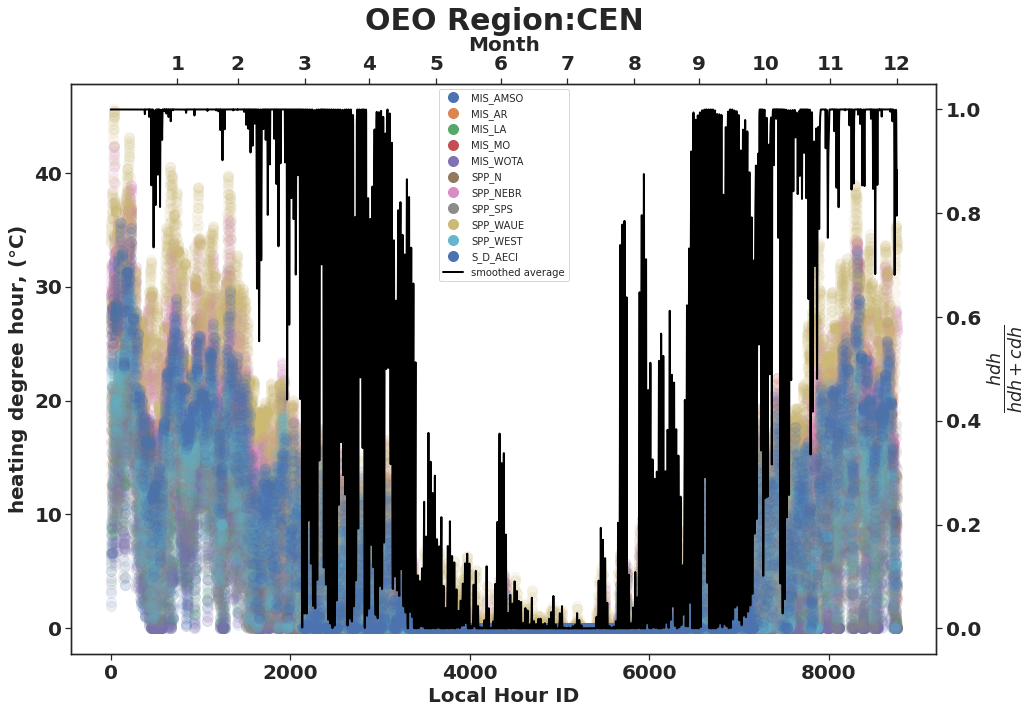

In [27]:
fig, axs = plt.subplots()

# plot specific variables:
OEO_region_to_plot = 'CEN'
x_axis = 'hour_ID'
y_axis = 'hdh'
smoothed_y_axis = 'hdh_frac'
smoothing_window = 1
x_label_font_size = 20
y_label_font_size = 20
plotting_regions = df_hourly_DD_plot[
    df_hourly_DD_plot['OEO_REGION'] ==
    OEO_region_to_plot]['IPM_REGION'].unique()
# plotting_regions = ['WECC_IID', 'WECC_SCE', 'WEC_BANC', 'WEC_CALN', 'WEC_LADW', 'WEC_SDGE']

df_plot_avg = df_hourlyDD_grouped_plot[df_hourlyDD_grouped_plot['OEO_REGION']
                                       == OEO_region_to_plot].copy()
# temp_df = df_hourly_DD_plot[df_hourly_DD_plot['Region'].isin(plotting_regions)].groupby(['OEO_REGION', 'hour_ID'])[['hdh', 'cdh']].mean().reset_index().copy()
# temp_df['hdh_frac'] = temp_df['hdh'] / (temp_df['hdh'] + temp_df['cdh'])
# temp_df['cdh_frac'] = temp_df['cdh'] / (temp_df['hdh'] + temp_df['cdh'])
# df_plot_avg = temp_df[temp_df['OEO_REGION'] == OEO_region_to_plot].copy()

for region_i in plotting_regions:
    df_plot_temp = df_hourly_DD_plot[(
        df_hourly_DD_plot['IPM_REGION'] == region_i)]
    axs.plot(x_axis,
             y_axis,
             data=df_plot_temp,
             marker='o',
             linestyle='None',
             markersize=10,
             alpha=0.10)

# plots the individual averaged values of hdh/cdh used for OEO regions
# axs.plot(x_axis, y_axis, data = df_plot_avg, marker = '*', color = 'black', linestyle = 'None', markersize = 6, alpha = 0.25)
temp_vector_y = smooth(df_plot_avg[smoothed_y_axis], smoothing_window)
temp_vector_x = df_plot_avg[x_axis]
# plots the smoothed averaged values of hdh/cdh used for OEO regions

sec_ax_y = axs.twinx()
# for legends on the same panel
add_sec_to_plot = sec_ax_y.plot(temp_vector_x,
                                temp_vector_y,
                                marker='None',
                                color='black',
                                linestyle='-',
                                linewidth=2,
                                label='smoothed')

handles, labels = axs.get_legend_handles_labels()
legend_labels = list(plotting_regions)
legend_labels.append('smoothed average')

# for legends on the same panel
leg = axs.legend(handles + add_sec_to_plot,
                 legend_labels,
                 fontsize=10,
                 loc='upper center')

sec_ax_x = axs.twiny()
new_tick_locations = np.array(func_cumulative_list(monthly_hours))
sec_ax_x.set_xlim(axs.get_xlim())
sec_ax_x.set_xticks(new_tick_locations)
sec_ax_x.set_xticklabels(np.arange(12) + 1)

sec_ax_x.set_xlabel(xlabel='Month',
                    fontweight='bold',
                    fontsize=x_label_font_size)
sec_ax_y.set_ylabel(ylabel=r'$\frac{hdh}{hdh+cdh}$',
                    fontweight='bold',
                    fontsize=y_label_font_size + 5)
axs.set_xlabel(xlabel='Local Hour ID',
               fontweight='bold',
               fontsize=x_label_font_size)
axs.set_ylabel(ylabel=r'heating degree hour, ($\degree$C)',
               fontweight='bold',
               fontsize=y_label_font_size)
axs.set_title('OEO Region:' + OEO_region_to_plot,
              fontweight='bold',
              fontsize=30)

for lh in leg.legendHandles:
    lh._legmarker.set_alpha(1)

for tick in axs.xaxis.get_majorticklabels():
    tick.set_fontsize(20)
    tick.set_fontweight('bold')

for tick in axs.yaxis.get_majorticklabels():
    tick.set_fontsize(20)
    tick.set_fontweight('bold')

for tick in sec_ax_x.xaxis.get_majorticklabels():
    tick.set_fontsize(20)
    tick.set_fontweight('bold')

for tick in sec_ax_y.yaxis.get_majorticklabels():
    tick.set_fontsize(20)
    tick.set_fontweight('bold')

fig.set_size_inches(15.5, 10.5)
# fig.savefig('./Documentation/Figures/hourly_hdh_CEN')

## Plotting separated heating and cooling loads for a single region

In [55]:
df_hourly_frames['Region_OEO'].unique()

array(['CA', 'NW', 'SW', 'TX', 'CEN', 'N_CEN', 'SE', 'MID_AT', 'NE'],
      dtype=object)

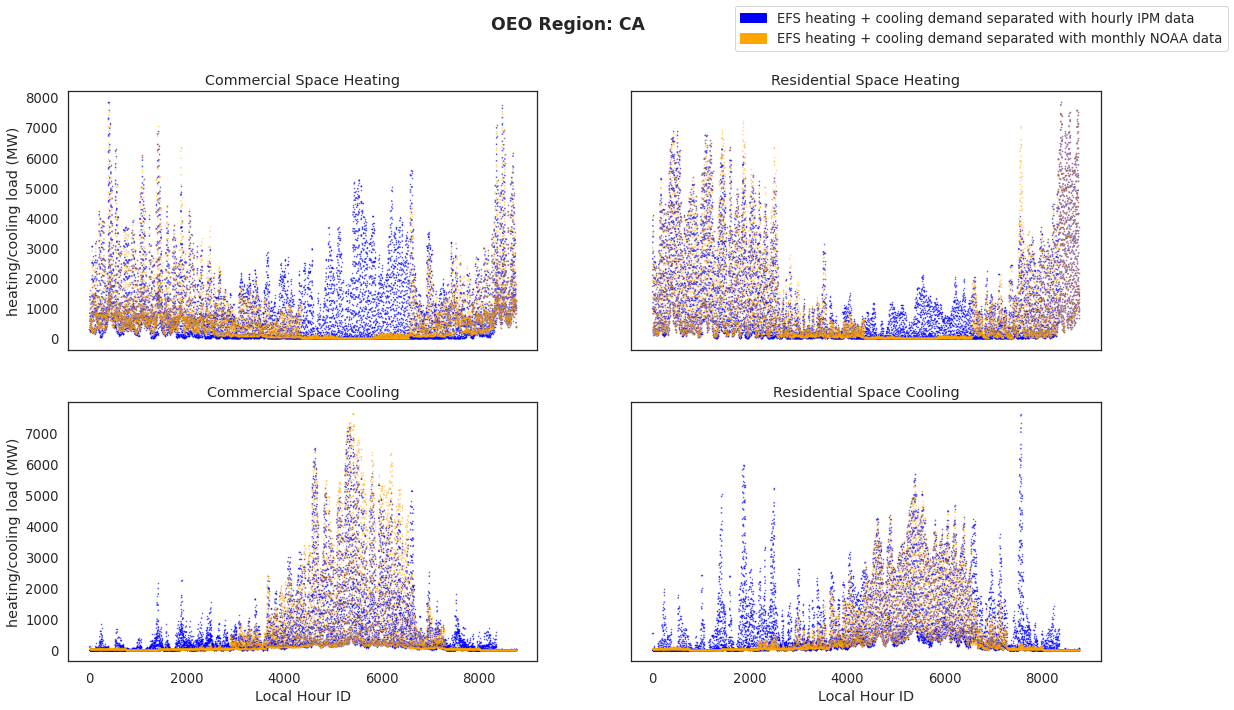

In [56]:
region = 'CA'
# dems_to_plot = df_hourly_frames['demand_name'].unique()
dems_to_plot = ['CSH', 'CSC', 'RSH', 'RSC']
fig, axs = plt.subplots(nrows=int(len(dems_to_plot) / 2), ncols=2)
row_iter_C = 0
row_iter_R = 0

for demand_cat in dems_to_plot:
    df_plot_hourly = df_hourly_frames.loc[
        (df_hourly_frames['Region_OEO'] == region)
        & (df_hourly_frames['demand_name'] == demand_cat)].copy()
    df_plot_monthly = df_monthly_frames.loc[
        (df_monthly_frames['Region_OEO'] == region)
        & (df_monthly_frames['demand_name'] == demand_cat)].copy()

    if demand_cat.startswith('C'):
        axs[row_iter_C, 0].plot('LocalHourID',
                                'dds',
                                data=df_plot_hourly,
                                linestyle=(0, (1, 10)),
                                color='blue',
                                marker='o',
                                markersize=0.5,
                                alpha=0.7)
        axs[row_iter_C, 0].plot('LocalHourID',
                                'dds',
                                data=df_plot_monthly,
                                linestyle=(0, (1, 10)),
                                color='orange',
                                marker='o',
                                markersize=0.5,
                                alpha=0.5)
        axs[row_iter_C, 0].set_title(demand_name_map[demand_cat])
        row_iter_C = row_iter_C + 1

    else:
        axs[row_iter_R, 1].plot('LocalHourID',
                                'dds',
                                data=df_plot_hourly,
                                linestyle=(0, (1, 10)),
                                color='blue',
                                marker='o',
                                markersize=0.5,
                                alpha=0.7)
        axs[row_iter_R, 1].plot('LocalHourID',
                                'dds',
                                data=df_plot_monthly,
                                linestyle=(0, (1, 10)),
                                color='orange',
                                marker='o',
                                markersize=0.5,
                                alpha=0.5)
        axs[row_iter_R, 1].set_title(demand_name_map[demand_cat])
        row_iter_R = row_iter_R + 1

for ax in axs.flat:
    ax.set(xlabel='Local Hour ID', ylabel='heating/cooling load (MW)')

for ax in axs.flat:
    ax.label_outer()

hourly_legend = mpatches.Patch(
    color='blue',
    label='EFS heating + cooling demand separated with hourly IPM data')
monthly_legend = mpatches.Patch(
    color='orange',
    label='EFS heating + cooling demand separated with monthly NOAA data')
fig.legend(handles=[hourly_legend, monthly_legend])
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(10.0)

fig.suptitle('OEO Region: ' + region, fontweight='bold')
fig.set_size_inches(18.5, 10.5)

## Saving figure in pdf:

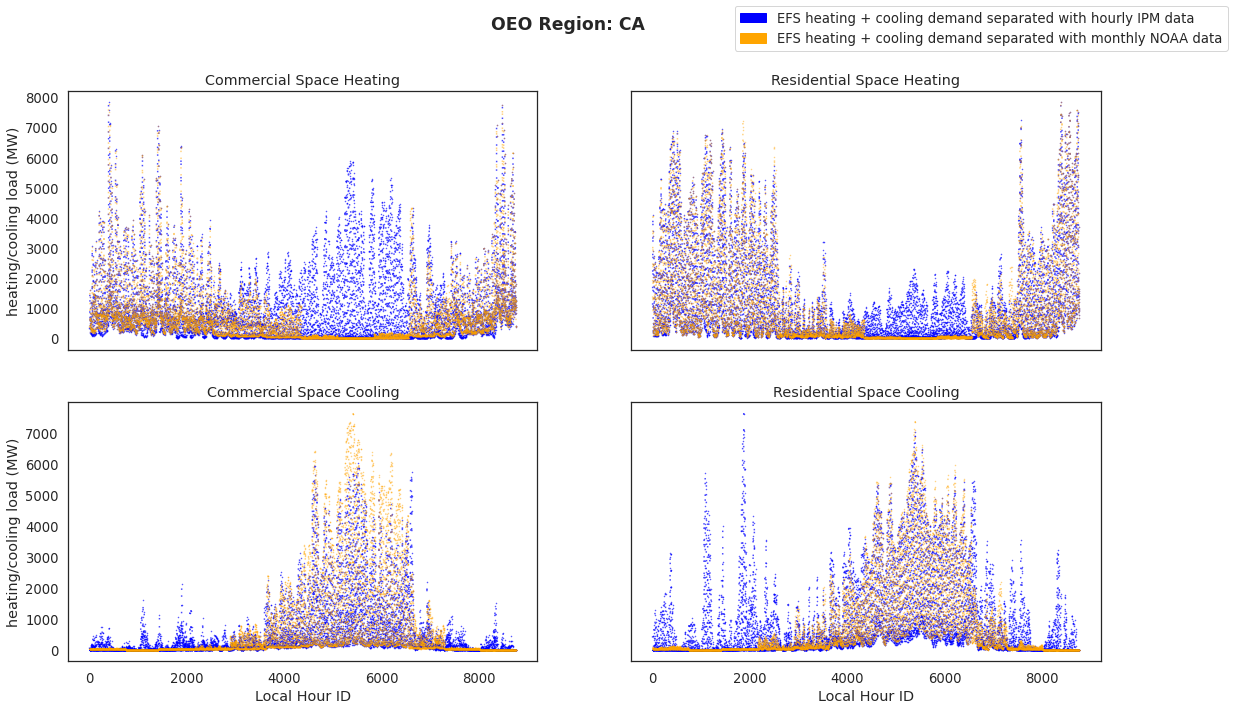

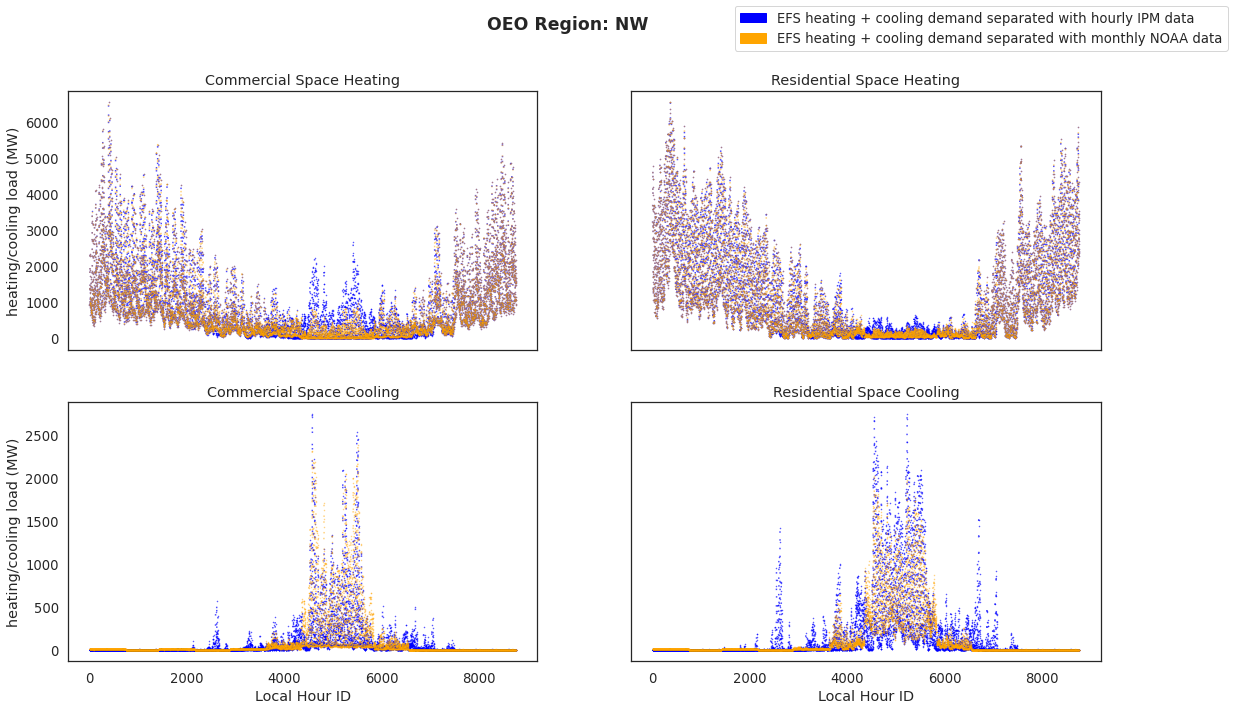

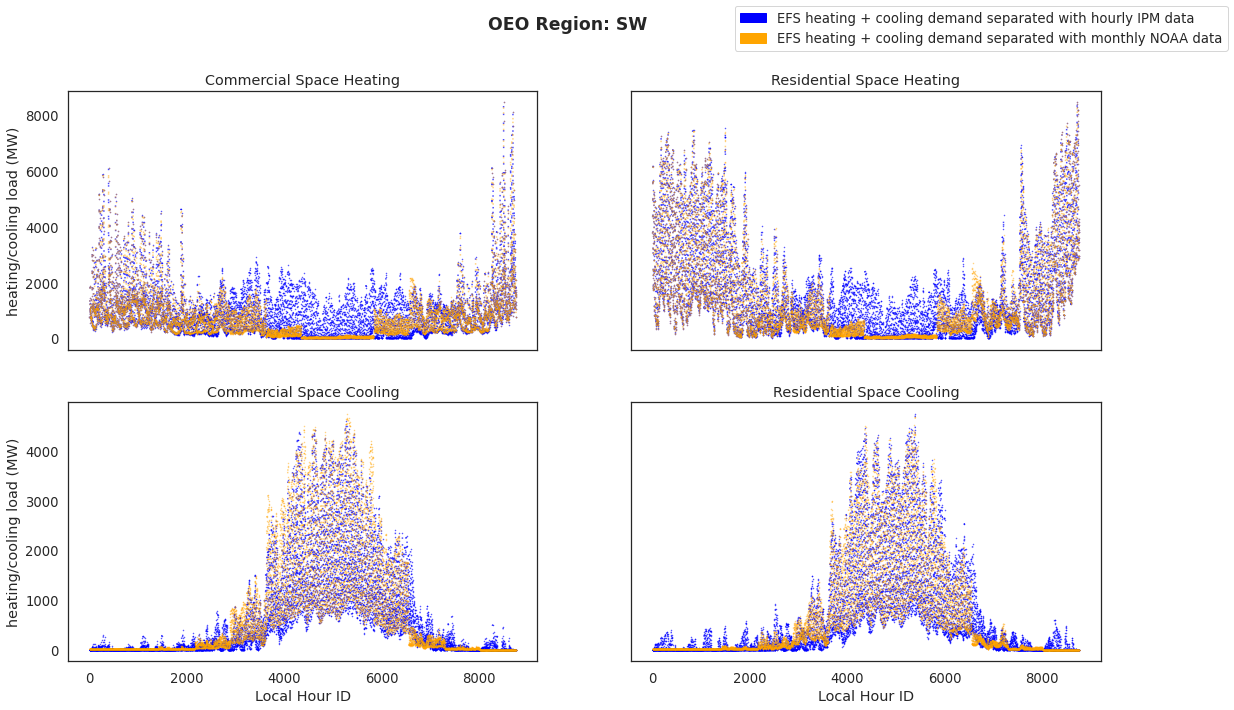

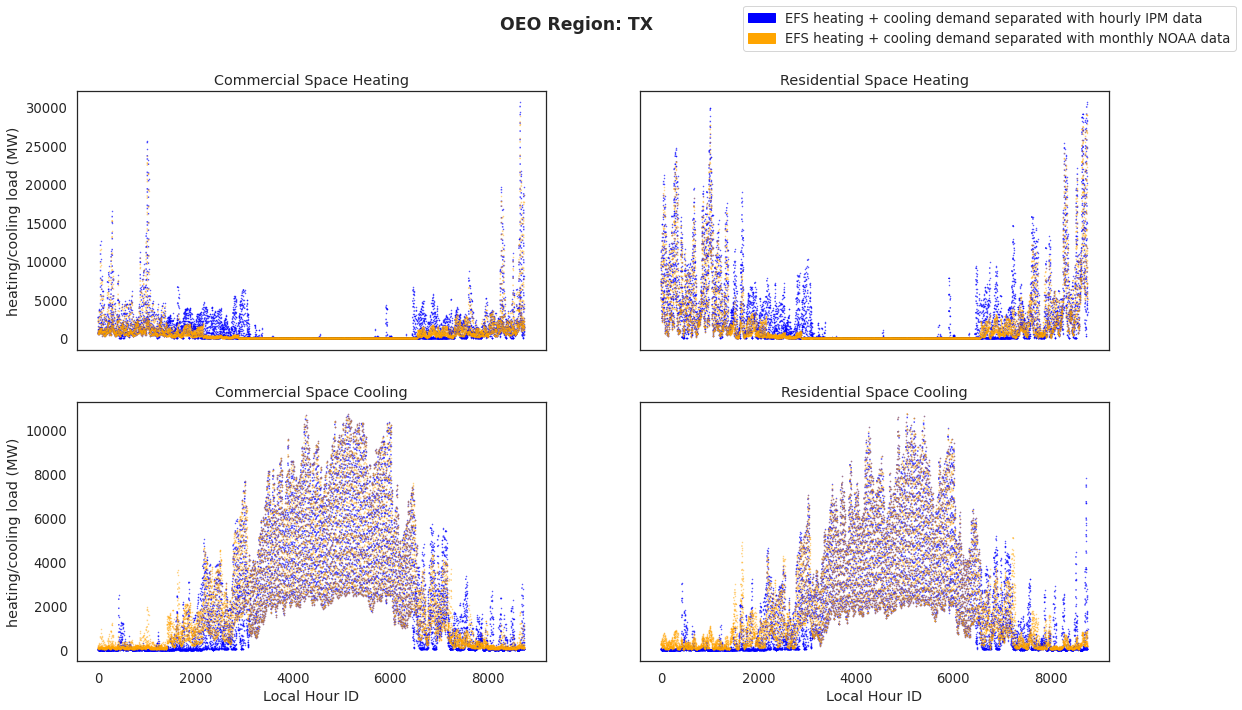

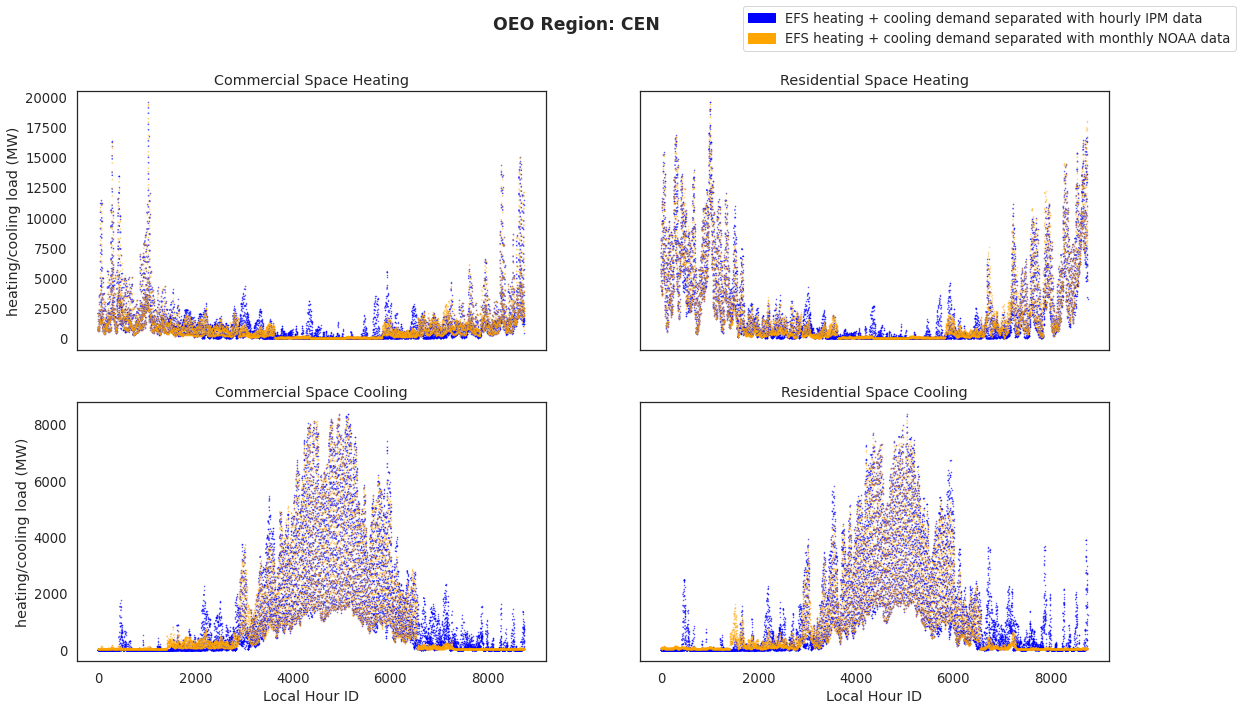

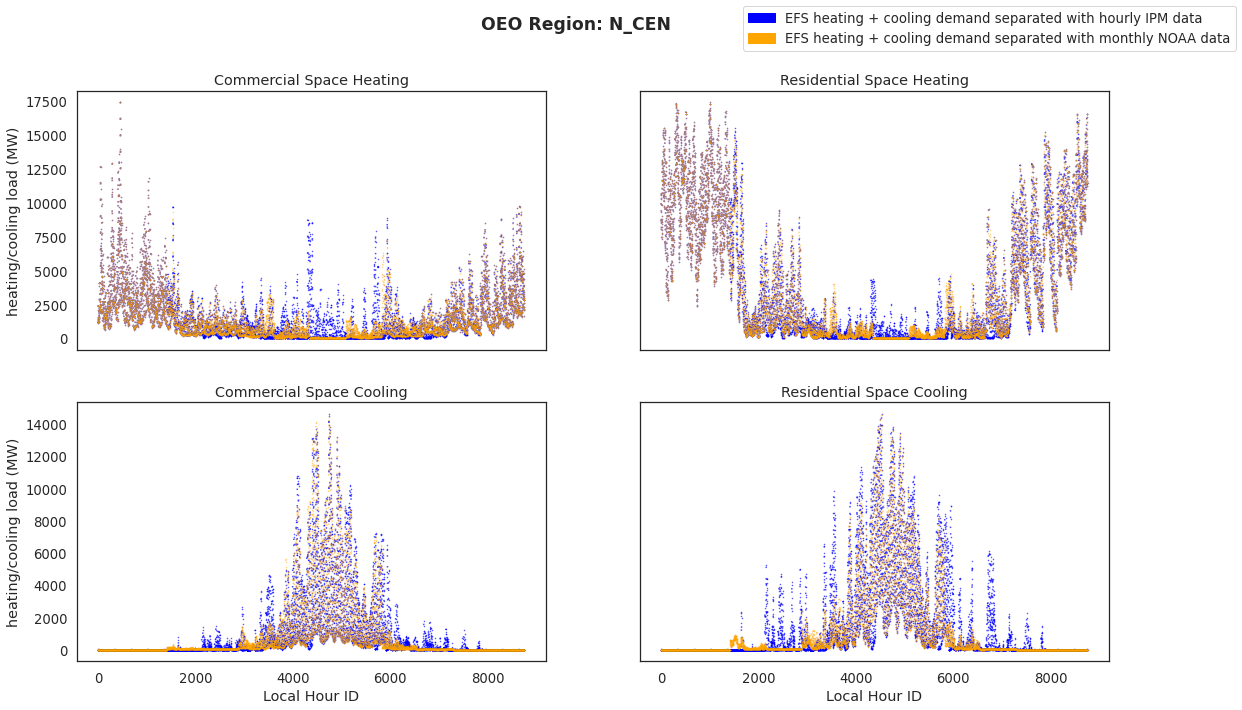

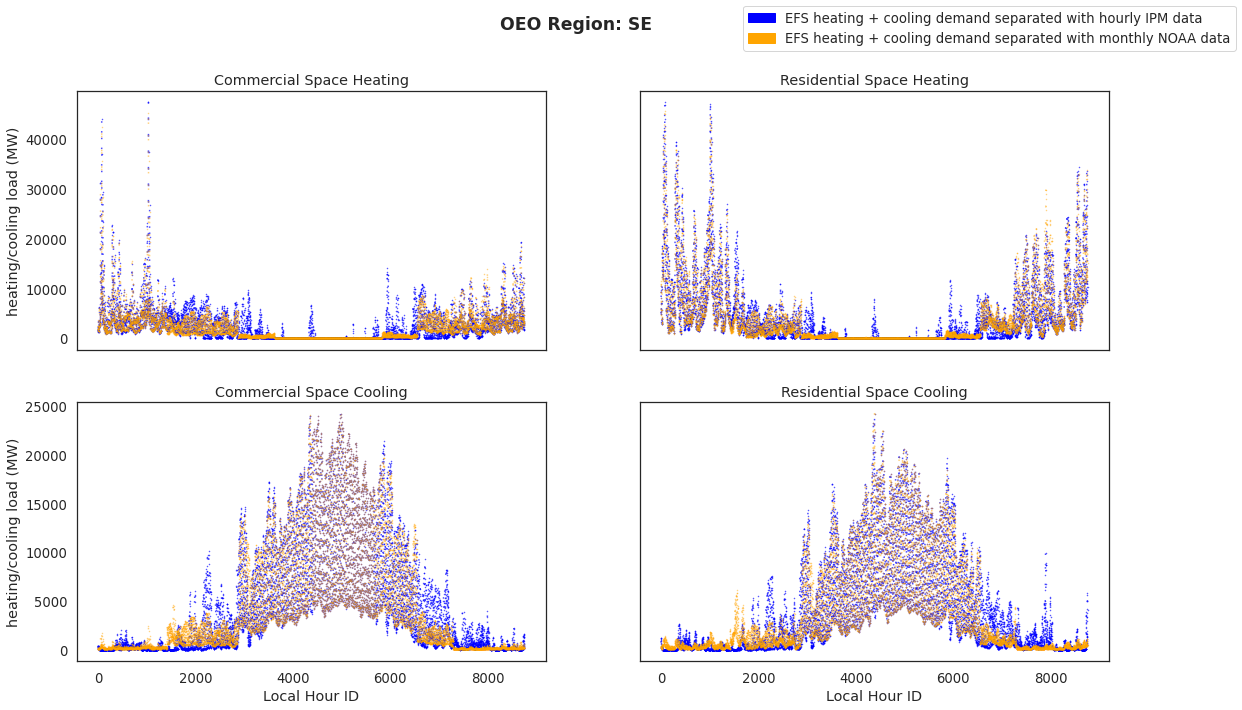

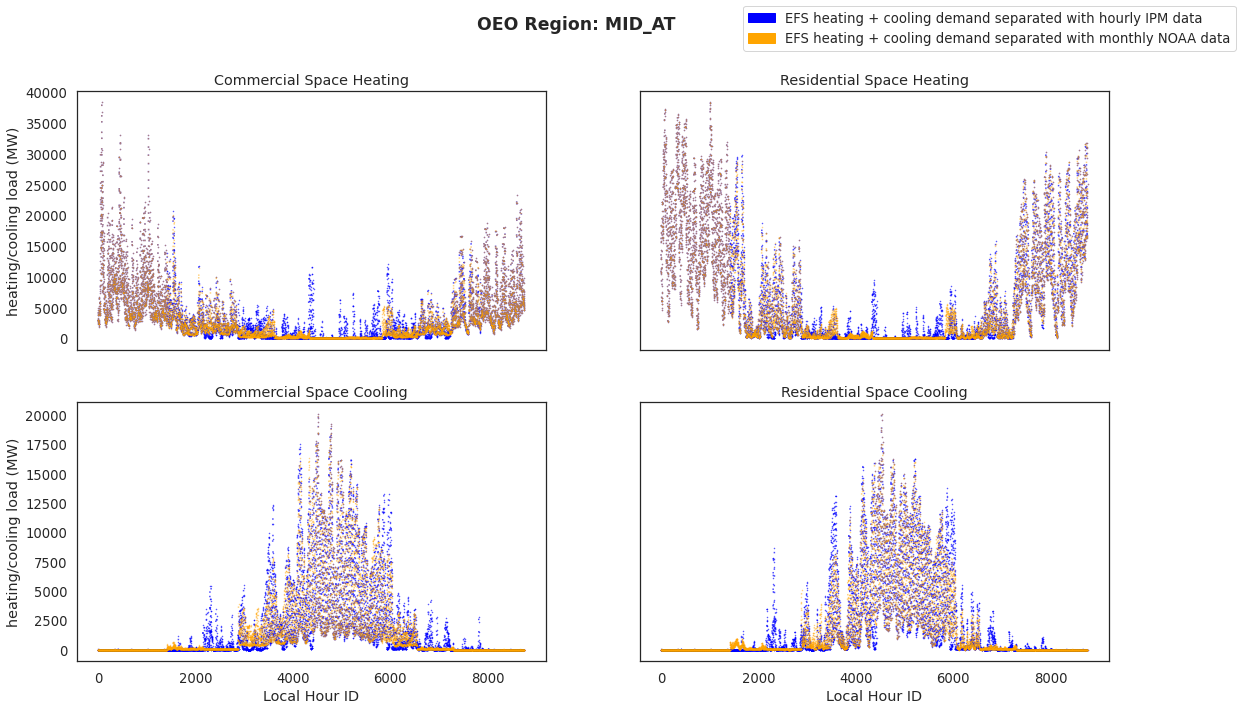

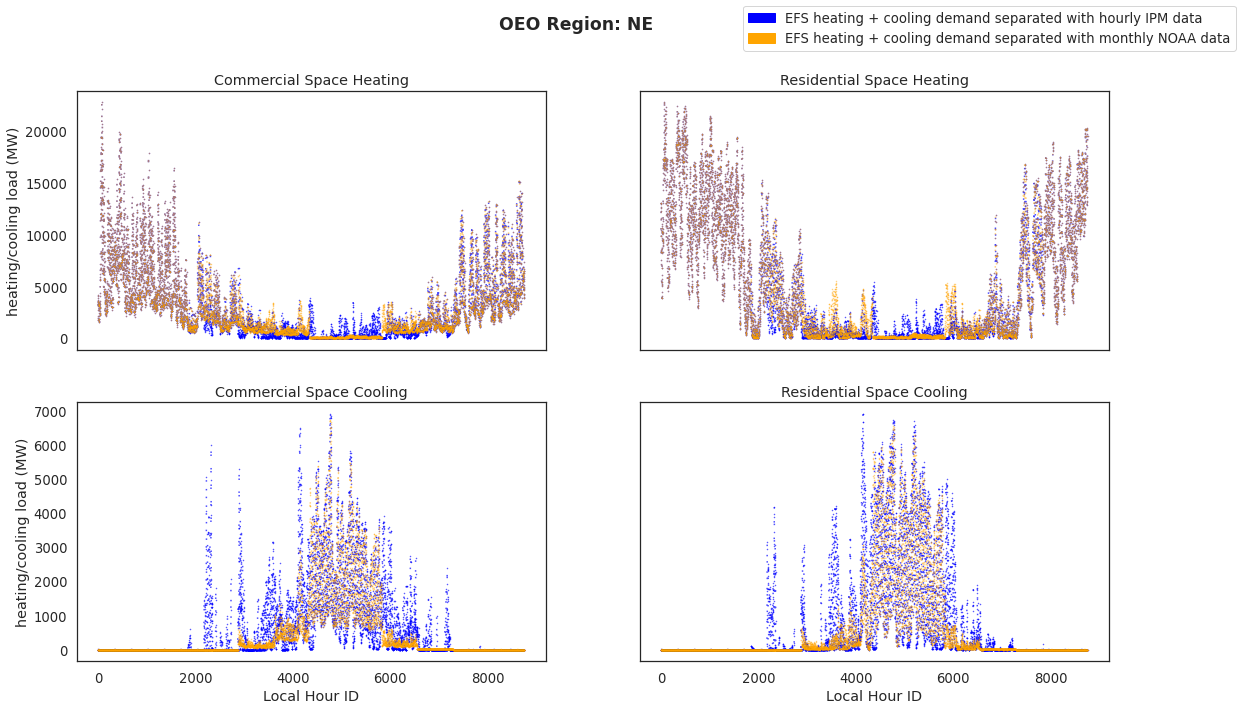

In [248]:
pdf = matplotlib.backends.backend_pdf.PdfPages("./Miscellaneous/EFS_hourly_demands.pdf")

for region in df_hourly_frames['Region_OEO'].unique():
    dems_to_plot = ['CSH', 'CSC', 'RSH', 'RSC']
    fig, axs = plt.subplots(nrows = int(len(dems_to_plot)/2), ncols = 2)
    row_iter_C = 0
    row_iter_R = 0

    for demand_cat in dems_to_plot:
        df_plot_hourly = df_hourly_frames.loc[(df_hourly_frames['Region_OEO'] == region) & (df_hourly_frames['demand_name'] == demand_cat)].copy()
        df_plot_monthly = df_monthly_frames.loc[(df_monthly_frames['Region_OEO'] == region) & (df_monthly_frames['demand_name'] == demand_cat)].copy()

        if demand_cat.startswith('C'):
            axs[row_iter_C, 0].plot('LocalHourID', 'dds', data=df_plot_hourly, linestyle = (0, (1, 10)), color = 'blue', marker = 'o', markersize = 0.5, alpha = 0.7)
            axs[row_iter_C, 0].plot('LocalHourID', 'dds', data=df_plot_monthly, linestyle = (0, (1, 10)), color = 'orange', marker = 'o', markersize = 0.5, alpha = 0.5)
            axs[row_iter_C, 0].set_title(demand_name_map[demand_cat])
            row_iter_C = row_iter_C + 1

        else:
            axs[row_iter_R, 1].plot('LocalHourID', 'dds', data=df_plot_hourly, linestyle = (0, (1, 10)), color = 'blue', marker = 'o', markersize = 0.5, alpha = 0.7)
            axs[row_iter_R, 1].plot('LocalHourID', 'dds', data=df_plot_monthly, linestyle = (0, (1, 10)), color = 'orange', marker = 'o', markersize = 0.5, alpha = 0.5)
            axs[row_iter_R, 1].set_title(demand_name_map[demand_cat])
            row_iter_R = row_iter_R + 1

    for ax in axs.flat:
        ax.set(xlabel='Local Hour ID', ylabel='heating/cooling load (MW)')

    for ax in axs.flat:
        ax.label_outer()

    fig.suptitle('OEO Region: ' + region, fontweight = 'bold')
    hourly_legend = mpatches.Patch(color='blue', label='EFS heating + cooling demand separated with hourly IPM data')
    monthly_legend = mpatches.Patch(color='orange', label='EFS heating + cooling demand separated with monthly NOAA data')
    fig.legend(handles=[hourly_legend, monthly_legend])
    fig.set_size_inches(18.5, 10.5)
    pdf.savefig( fig )
pdf.close()

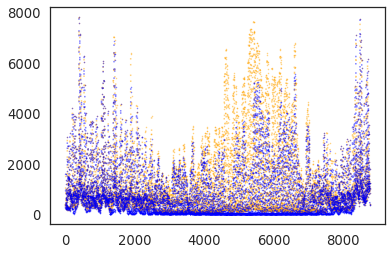

In [57]:
df_temp_plot = df_OEO_hourlyDD.loc[(df_OEO_hourlyDD['Sector'] == 'Commercial') & (df_OEO_hourlyDD['Subsector'] == 'space heating and cooling') & (df_OEO_hourlyDD['OEO_REGION'] == 'CA')].copy()
plt.plot('LocalHourID', 'loadMW_sum', data=df_temp_plot, linestyle = (0, (1, 10)), color = 'orange', marker = 'o', markersize = 0.5, alpha = 0.5)
plt.plot('LocalHourID', 'heating_loadMW', data=df_temp_plot, linestyle = (0, (1, 10)), color = 'blue', marker = 'o', markersize = 0.5, alpha = 0.5)

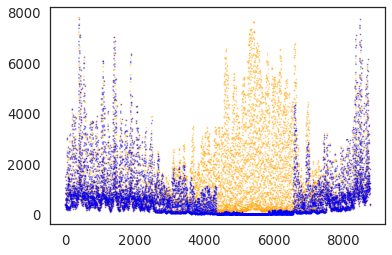

In [29]:
df_temp_plot_2 = df_OEO_monthlyDD.loc[(df_OEO_monthlyDD['Sector'] == 'Commercial') & (df_OEO_monthlyDD['Subsector'] == 'space heating and cooling') & (df_OEO_monthlyDD['Region_OEO'] == 'CA')].copy()
plt.plot('LocalHourID', 'loadMW_sum', data=df_temp_plot_2, linestyle = (0, (1, 10)), color = 'orange', marker = 'o', markersize = 0.5, alpha = 0.5)
plt.plot('LocalHourID', 'heating_loadMW', data=df_temp_plot_2, linestyle = (0, (1, 10)), color = 'blue', marker = 'o', markersize = 0.5, alpha = 0.5)

# Miscellaneous

## Get EFS load profiles

In [ ]:
#this downloads the NREL EFS dataset to be parsed locally
# if 'service_demand_hourly.csv' not in os.listdir():
#     url = 'https://data.nrel.gov/system/files/126/EFSLoadProfile_High_Rapid.zip'
#     filename =  os.getcwd() + '/' + url.split('/') [-1]
#     r = urllib.request.urlretrieve(url,filename)

#     fp = open('service_demand_hourly.csv', 'wb')
#     with gzip.open(filename, 'rb') as f:
#         data = f.read()
#     fp.write(data)
#     fp.close()

## Old script from Aranya' work

In [16]:
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='COMMERCIAL AIR CONDITIONING', 'VALUE'] *=(1055.06/1000)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='COMMERCIAL SPACE HEATING', 'VALUE'] *=(1055.06/1000)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='COMMERCIAL WATER HEATING', 'VALUE'] *=(1055.06/1000)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='COMMERCIAL REFRIGERATION', 'VALUE'] *=(1055.06/1000)

df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='RESIDENTIAL SPACE HEATING', 'VALUE'] *=(1055.06/10**9)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='RESIDENTIAL AIR CONDITIONING', 'VALUE'] *=(1055.06/10**9)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='RESIDENTIAL WATER HEATING', 'VALUE'] *=(1055.06/10**9)

In [17]:
#create US_National.sqlite file in the main directory from the US_National.sql file before running this cell.
con = sqlite3.connect('../../US_National.sqlite')
c = con.cursor()
df_national_demands = pd.read_sql_query("SELECT * FROM Demand \
WHERE substr(demand_comm,1,1) = 'C'\
OR substr(demand_comm,1,1) = 'R'", con)

df_national_comms = pd.read_sql_query("SELECT * FROM commodities\
                                      WHERE comm_name IN\
                                      (SELECT DISTINCT(demand_comm) FROM Demand\
                                      WHERE substr(demand_comm,1,1) = 'C'\
                                      OR substr(demand_comm,1,1) = 'R')", con)
orig_cols = df_national_demands.columns

con.commit()
con.close()
df_national_comms


comm_name flag                                          comm_desc
0        CCK    d                        # commercial cooking demand
1        CLT    d                       # commercial lighting demand
2     COEELC    d  # commercial electric demand for office equipment
3      COELC    d                 # commercial other electric demand
4      CORFO    d        # commercial other residual fuel oil demand
5     COTHER    d                 #Other demand in commercial sector
6        CRF    d                  # commercial refrigeration demand
7        CSC    d                  # commercial space cooling demand
8        CSH    d                  # commercial space heating demand
9        CVT    d                    # commercial ventilation demand
10       CWH    d                  # commercial water heating demand
11       RFZ    d                      # residential freezing demand
12       RLT    d                      # residential lighting demand
13     ROELC    d                # residential other electric demand
14    ROTHER    d                #Other demand in resindetial sector
15       RRF    d                 # residential refrigeration demand
16       RSC    d                 # residential space cooling demand
17       RSH    d                 # residential space heating demand
18       RWH    d                 # residential water heating demand

In [18]:
map_temoa_efs_demands = dict()
map_temoa_efs_demands['CSC'] = 'COMMERCIAL AIR CONDITIONING'#PJ, TBTU
map_temoa_efs_demands['CSH'] = 'COMMERCIAL SPACE HEATING'#PJ, TBTU
map_temoa_efs_demands['CWH'] = 'COMMERCIAL WATER HEATING'#PJ, TBTU
map_temoa_efs_demands['CRF'] = 'COMMERCIAL REFRIGERATION'#PJ, TBTU
map_temoa_efs_demands['CLT'] = 'COMMERCIAL LIGHTING'#bn-lum, GIGALUMEN_YEAR
map_temoa_efs_demands['CVT'] = 'COMMERCIAL VENTILATION'#tcfm-hr, GIGACUBIC_FOOT
map_temoa_efs_demands['CCK'] = 'COMMERCIAL COOKING'#PJ, TBTU
#assigning commercial lighting to all other demands
map_temoa_efs_demands['COELC'] = 'COMMERCIAL LIGHTING'#PJ, GIGALUMEN_YEAR
map_temoa_efs_demands['COEELC'] = 'COMMERCIAL LIGHTING'#PJ, GIGALUMEN_YEAR
map_temoa_efs_demands['CORFO'] = 'COMMERCIAL LIGHTING'#PJ, GIGALUMEN_YEAR
map_temoa_efs_demands['COTHER'] = 'COMMERCIAL LIGHTING'#PJ, GIGALUMEN_YEAR



map_temoa_efs_demands['RSC'] = 'RESIDENTIAL AIR CONDITIONING'#PJ, MMBTU
map_temoa_efs_demands['RSH'] = 'RESIDENTIAL SPACE HEATING'#PJ, MMBTU
map_temoa_efs_demands['RWH'] = 'RESIDENTIAL WATER HEATING'#PJ, MMBTU
map_temoa_efs_demands['RRF'] = 'RESIDENTIAL REFRIGERATION'#PJ, cubic-feet
map_temoa_efs_demands['RFZ'] = 'RESIDENTIAL FREEZING'#PJ, cubic-feet
map_temoa_efs_demands['RLT'] = 'RESIDENTIAL LIGHTING'#bn-lum, KILOLUMEN_HOUR
map_temoa_efs_demands['ROELC'] = 'RESIDENTIAL DISHWASHING'#PJ, CYCLE
map_temoa_efs_demands['ROTHER'] = 'RESIDENTIAL CLOTHES DRYING'#PJ, lb
#residential missing the following:
#RESIDENTIAL CLOTHES WASHING	CUBIC_FOOT_CYCLE
#RESIDENTIAL COOKING	MMBTU

In [19]:
emptydB = '../../US_National.sqlite'
conn = sqlite3.connect(emptydB)
df_demand_desc = pd.read_sql("SELECT comm_name, comm_desc FROM commodities", conn)

In [20]:
map_efs_temoa_demands ={}
for k, v in map_temoa_efs_demands.items():
    if v not in map_efs_temoa_demands.keys():
        map_efs_temoa_demands[v] = df_demand_desc.loc[df_demand_desc.comm_name==k,'comm_desc'].values[0].replace('#','').strip()
    else:
        map_efs_temoa_demands[v] = map_efs_temoa_demands[v]+ ', ' + df_demand_desc.loc[df_demand_desc.comm_name==k,'comm_desc'].values[0].replace('#','').strip()
    

In [21]:
df_state_demands_cap['OEO demands'] = df_state_demands_cap['SUBSECTOR'].map(map_efs_temoa_demands)
df_state_demands_cap['SUBSECTOR'] = df_state_demands_cap['SUBSECTOR'].str.capitalize()
df_state_demands_cap

SUBSECTOR              UNIT  \
0      Commercial air conditioning           TERABTU   
9               Commercial cooking           TERABTU   
18             Commercial lighting    GIGALUMEN_YEAR   
27        Commercial refrigeration           TERABTU   
36        Commercial space heating           TERABTU   
45          Commercial ventilation    GIGACUBIC_FOOT   
54        Commercial water heating           TERABTU   
1953  Residential air conditioning             MMBTU   
1962    Residential clothes drying                LB   
1971   Residential clothes washing  CUBIC_FOOT_CYCLE   
1980           Residential cooking             MMBTU   
1989       Residential dishwashing             CYCLE   
1998          Residential freezing        CUBIC_FEET   
2007          Residential lighting    KILOLUMEN_HOUR   
2016     Residential refrigeration        CUBIC_FEET   
2025     Residential space heating             MMBTU   
2034     Residential water heating             MMBTU   

                                            OEO demands  
0                       commercial space cooling demand  
9                             commercial cooking demand  
18    commercial lighting demand, commercial other e...  
27                      commercial refrigeration demand  
36                      commercial space heating demand  
45                        commercial ventilation demand  
54                      commercial water heating demand  
1953                   residential space cooling demand  
1962                 Other demand in resindetial sector  
1971                                                NaN  
1980                                                NaN  
1989                  residential other electric demand  
1998                        residential freezing demand  
2007                        residential lighting demand  
2016                   residential refrigeration demand  
2025                   residential space heating demand  
2034                   residential water heating demand

In [22]:
df_state_demands_cap.loc[18,'OEO demands']

'commercial lighting demand, commercial other electric demand, commercial electric demand for office equipment, commercial other residual fuel oil demand, Other demand in commercial sector'

In [23]:
df_national_demands['SUBSECTOR'] = df_national_demands['demand_comm'].map(map_temoa_efs_demands)
df_national_demands_merged = df_national_demands.merge(df_state_demands_national, right_on=['SUBSECTOR', 'YEAR'], left_on=['SUBSECTOR', 'periods'])

In [24]:
df_national_demands_merged

regions  periods demand_comm       demand demand_units demand_notes  \
0        US     2020         RWH  1372.553288          #PJ         NULL   
1        US     2025         RWH  1421.000945          #PJ         NULL   
2        US     2030         RWH  1456.054780          #PJ         NULL   
3        US     2035         RWH  1457.799232          #PJ         NULL   
4        US     2040         RWH  1452.105202          #PJ         NULL   
..      ...      ...         ...          ...          ...          ...   
128      US     2030         CCK   142.821282          #PJ         NULL   
129      US     2035         CCK   150.686605          #PJ         NULL   
130      US     2040         CCK   158.134618          #PJ         NULL   
131      US     2045         CCK   165.950436          #PJ         NULL   
132      US     2050         CCK   174.152240          #PJ         NULL   

                     SUBSECTOR  YEAR        VALUE           SUM  \
0    RESIDENTIAL WATER HEATING  2020  1277.164099  1.089462e+10   
1    RESIDENTIAL WATER HEATING  2025  1293.224986  1.103162e+10   
2    RESIDENTIAL WATER HEATING  2030  1328.315697  1.133096e+10   
3    RESIDENTIAL WATER HEATING  2035  1378.381993  1.175804e+10   
4    RESIDENTIAL WATER HEATING  2040  1434.793862  1.223925e+10   
..                         ...   ...          ...           ...   
128         COMMERCIAL COOKING  2030   247.846088  2.230615e+03   
129         COMMERCIAL COOKING  2035   260.488231  2.344394e+03   
130         COMMERCIAL COOKING  2040   273.335596  2.460020e+03   
131         COMMERCIAL COOKING  2045   286.295321  2.576658e+03   
132         COMMERCIAL COOKING  2050   299.183367  2.692650e+03   

     regional_fraction  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
..                 ...  
128                1.0  
129                1.0  
130                1.0  
131                1.0  
132                1.0  

[133 rows x 11 columns]

In [25]:
#df_state_demands[['SUBSECTOR', 'UNIT']].drop_duplicates().to_csv('NREL_service_demands.csv')

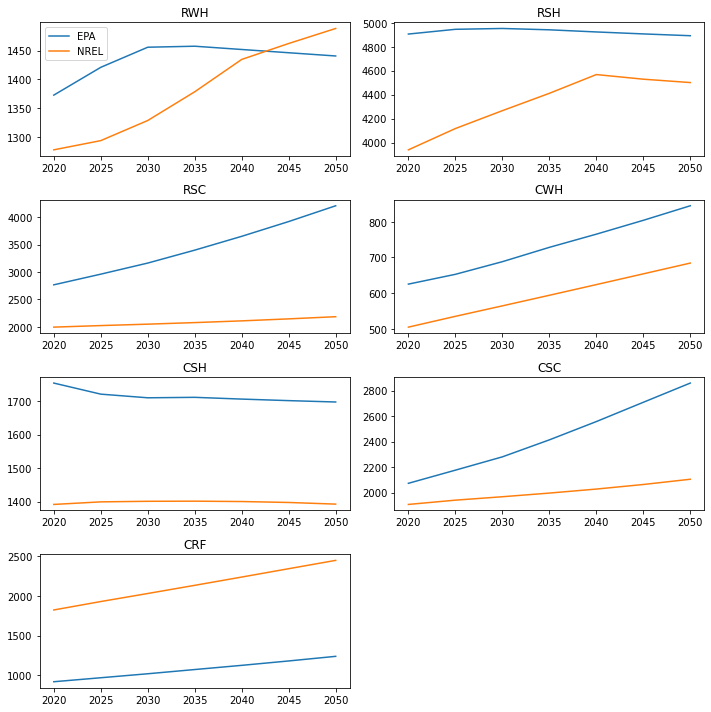

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
i=1
for sub in df_national_demands_merged.demand_comm.unique():
    if sub in ['CSC', 'CSH', 'CWH', 'CRF', 'RSC', 'RSH', 'RWH']:
        plt.subplot(4,2,i)
        df_plot = df_national_demands_merged[df_national_demands_merged.demand_comm==sub]
        plt.title(sub)
        plt.plot(df_plot.periods, df_plot.demand, label='EPA')
        plt.plot(df_plot.periods, df_plot.VALUE, label='NREL')
        if i==1:
            plt.legend()
        i+=1
plt.tight_layout()



In [27]:
df_temoa_mod_demands_all = pd.DataFrame()
for region in df_state_demands.Region.unique():
    df_temoa_mod_demands = df_national_demands.copy()
    df_temoa_mod_demands['regions'] = region
    df_nrel_demands = df_state_demands[df_state_demands.Region==region]
    df_temoa_mod_demands = df_temoa_mod_demands.merge(df_nrel_demands, right_on = ['SUBSECTOR', 'YEAR'], \
                                                     left_on = ['SUBSECTOR','periods'])
    df_temoa_mod_demands['demand'] *= df_temoa_mod_demands['regional_fraction']
    df_temoa_mod_demands_all = pd.concat([df_temoa_mod_demands_all, df_temoa_mod_demands[orig_cols]])

In [28]:
df_temoa_mod_demands[df_temoa_mod_demands.demand_comm=='RSH']

regions  periods demand_comm      demand demand_units demand_notes  \
7       NE     2020         RSH  930.990859          #PJ         NULL   
8       NE     2025         RSH  939.905064          #PJ         NULL   
9       NE     2030         RSH  942.323853          #PJ         NULL   
10      NE     2035         RSH  941.761468          #PJ         NULL   
11      NE     2040         RSH  938.868717          #PJ         NULL   
12      NE     2045         RSH  922.836410          #PJ         NULL   
13      NE     2050         RSH  906.632546          #PJ         NULL   

                    SUBSECTOR Region  YEAR   UNIT         VALUE           SUM  \
7   RESIDENTIAL SPACE HEATING     NE  2020  MMBTU  7.085615e+08  3.733689e+09   
8   RESIDENTIAL SPACE HEATING     NE  2025  MMBTU  7.416354e+08  3.902152e+09   
9   RESIDENTIAL SPACE HEATING     NE  2030  MMBTU  7.693892e+08  4.043515e+09   
10  RESIDENTIAL SPACE HEATING     NE  2035  MMBTU  7.968420e+08  4.180790e+09   
11  RESIDENTIAL SPACE HEATING     NE  2040  MMBTU  8.255702e+08  4.329178e+09   
12  RESIDENTIAL SPACE HEATING     NE  2045  MMBTU  8.072997e+08  4.292582e+09   
13  RESIDENTIAL SPACE HEATING     NE  2050  MMBTU  7.906290e+08  4.265938e+09   

    regional_fraction  
7            0.189775  
8            0.190058  
9            0.190277  
10           0.190596  
11           0.190699  
12           0.188069  
13           0.185335

In [29]:
#this is the final csv file that is used to create the US_Regional.sqlite database elsewhere
df_temoa_mod_demands_all.to_csv('buildings_regional_demands_adjusted.csv')

## Miscellaneous Code Snippets

Text(0.5, 1.0, 'Residential Sector - CEN')

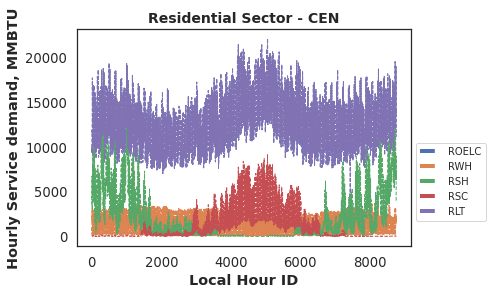

In [95]:
temp_result = temp_result.loc[(temp_result['Region_OEO'] == 'CEN')]
temp_store = temp_result[['Region_OEO','demand_name']].drop_duplicates()
temp_store_1 = temp_store.demand_name.str.startswith('R')
list_to_sub_res = list(temp_store.loc[temp_store_1]['demand_name'])

fig, ax = plt.subplots()

for subsector in list_to_sub_res:
    df_plot = temp_result.loc[temp_result['demand_name'] == subsector].reset_index()
    ax.plot(df_plot["LocalHourID"], df_plot["dds"], '--', label=subsector, linewidth = 1)


SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.xlabel(r'\textbf{Year}')
# plt.ylabel(r'\textbf{Service demand, MMBTU}')
plt.xlabel('Local Hour ID', fontweight = "bold")
plt.ylabel('Hourly Service demand, MMBTU', fontweight = "bold")

leg = ax.legend(bbox_to_anchor=(1, 0.5))
for line in leg.get_lines():
    line.set_linewidth(4)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# labels = ['Space Heating', 'Water Heating', 'Air Conditioning', 'Cooking']
# plt.legend(labels, loc = 'center', bbox_to_anchor=(0.5, 0.5))
plt.title('Residential Sector - CEN', fontweight="bold", fontsize = 14)

In [80]:
temp_result.keys()

Index(['LocalHourID', 'Region_OEO', 'dds', 'demand_name'], dtype='object')

In [39]:
df_hourly_2050_RES = df_demands_hourly_2050[df_demands_hourly_2050['Sector']=='Residential']#.reset_index() 
df_hourly_2050_COMM = df_demands_hourly_2050[df_demands_hourly_2050['Sector']=='Commercial']#.reset_index() 

In [40]:
df_hourly_2050_RES = df_hourly_2050_RES[df_hourly_2050_RES['Subsector']=='space heating and cooling']#.reset_index() 
df_hourly_2050_COMM = df_hourly_2050_COMM[df_hourly_2050_COMM['Subsector']=='space heating and cooling']#.reset_index() 

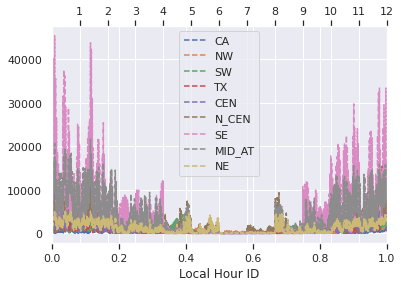

In [81]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

new_tick_locations = np.array([730, 730 * 2,  730 * 3,  730 * 4,  730 * 5,  730 * 6,  730 * 7,  730 * 8,  730 * 9,  730 * 10,  730 * 11,  730 * 12])

for region in df_hourly_2018_RES.Region_OEO.unique():
    df_plot = df_hourly_2018_RES[df_hourly_2018_RES['Region_OEO'] == region].reset_index()
    plt.plot(df_plot.LocalHourID, df_plot["heating_loadMW"], '--', label=region)
  

def tick_function(X):
    V = X / 730
    return ["%.0f" % z for z in V]

ax1.set_xlabel(r"Local Hour ID")
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
plt.legend()

# ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks()
# ax2.set_xticklabels(tick_function(new_tick_locations))
# plt.savefig('RESIDENTIAL SPACE HEATING.png', transparent = True, bbox_inches='tight')


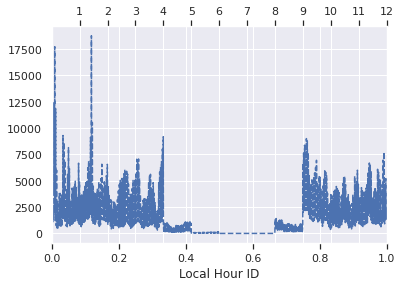

In [103]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

new_tick_locations = np.array([730, 730 * 2,  730 * 3,  730 * 4,  730 * 5,  730 * 6,  730 * 7,  730 * 8,  730 * 9,  730 * 10,  730 * 11,  730 * 12])

df_plot = df_hourly_2018_COMM[df_hourly_2018_COMM['Region_OEO'] == 'SE'].reset_index()
plt.plot(df_plot.LocalHourID, df_plot["heating_loadMW"], '--', label=region)

def tick_function(X):
    V = X / 730
    return ["%.0f" % z for z in V]

ax1.set_xlabel(r"Local Hour ID")
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
# plt.legend()

# ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks()
# ax2.set_xticklabels(tick_function(new_tick_locations))
plt.savefig('CA_COMM_heat.png', transparent = False, bbox_inches='tight')

In [74]:
def tick_function(X):
    V = X / 730
    return ["%.1f" % z for z in V]

new_tick_locations = np.array([730, 730 * 2,  730 * 3,  730 * 4,  730 * 5,  730 * 6,  730 * 7,  730 * 8,  730 * 9,  730 * 10,  730 * 11,  730 * 12])

tick_function(new_tick_locations)

['1.0',
 '2.0',
 '3.0',
 '4.0',
 '5.0',
 '6.0',
 '7.0',
 '8.0',
 '9.0',
 '10.0',
 '11.0',
 '12.0']

In [32]:
df_demands_hourly_regFrac['regional_fraction'] = df_demands_hourly_regFrac['loadMW_sum_x']/df_demands_hourly_regFrac['loadMW_sum_y']

In [33]:
#df_state_demands_hourly_spacehc = df_state_demands_hourly_temp[(df_state_demands_hourly_temp.loc[:,'Sector']=='Residential') & (df_state_demands_hourly_temp.loc[:,'Subsector']=='space heating and cooling') & (df_state_demands_hourly_temp.loc[:,'Year']==2050) & (df_state_demands_hourly_temp.loc[:,'Region_OEO']=='CEN')]
df_state_demands_hourly_spacehc = df_state_demands_hourly_temp[(df_state_demands_hourly_temp.loc[:,'Sector']=='Commercial') & (df_state_demands_hourly_temp.loc[:,'Subsector']=='space heating and cooling') & (df_state_demands_hourly_temp.loc[:,'Region_OEO']=='CA')]


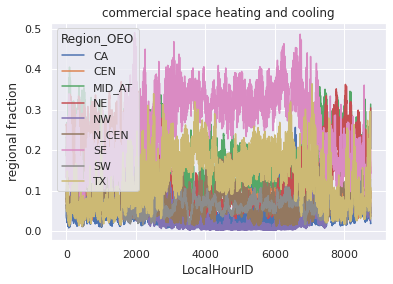

In [34]:
df_hourly_sector = df_demands_hourly_regFrac.loc[(df_demands_hourly_regFrac.loc[:,'Sector']=='Commercial') & (df_demands_hourly_regFrac.loc[:,'Year']==2050) & (df_demands_hourly_regFrac.loc[:,'Subsector']=='space heating and cooling')]
df_hourly_sectorpivot = df_hourly_sector.pivot(index = 'LocalHourID', columns = 'Region_OEO', values = 'regional_fraction')
# df_state_demands_sectorpivot
df_hourly_sectorpivot.plot(kind = 'line', title='commercial space heating and cooling', ylabel='regional fraction')
plt.savefig('RESIDENTIAL SPACE HEATING.png', transparent = True, bbox_inches='tight')

In [106]:
#calculate annual sum across all regions
df_state_demands_reg_frac = df_state_demands.groupby(['YEAR','SUBSECTOR']).sum().reset_index()
df_state_demands_reg_frac.rename(columns={'VALUE':'SUM'}, inplace=True)
#merge original df with annual sum across all regions
df_state_demands = df_state_demands.merge(df_state_demands_reg_frac, on=['YEAR', 'SUBSECTOR'])
#calculate regional fractions of each demand subsector
df_state_demands['regional_fraction'] = df_state_demands['VALUE']/df_state_demands['SUM']
df_state_demands.head()


Region  YEAR                    SUBSECTOR     UNIT       VALUE          SUM  \
0     CA  2020  COMMERCIAL AIR CONDITIONING  TERABTU  141.872688  1807.972404   
1     NW  2020  COMMERCIAL AIR CONDITIONING  TERABTU   11.386015  1807.972404   
2     SW  2020  COMMERCIAL AIR CONDITIONING  TERABTU   79.360701  1807.972404   
3     TX  2020  COMMERCIAL AIR CONDITIONING  TERABTU  302.306333  1807.972404   
4    CEN  2020  COMMERCIAL AIR CONDITIONING  TERABTU  167.261941  1807.972404   

   regional_fraction  
0           0.078471  
1           0.006298  
2           0.043895  
3           0.167207  
4           0.092514

In [79]:
#df_state_demands.columns
df_state_demands_hourly_temp.to_csv('EFS_buildings_regional_demands_hourly.csv')

In [14]:
df_state_demands_national = df_state_demands.groupby(['SUBSECTOR','YEAR']).sum().reset_index()
df_state_demands_national

SUBSECTOR  YEAR         VALUE           SUM  \
0    COMMERCIAL AIR CONDITIONING  2020  1.807972e+03  1.627175e+04   
1    COMMERCIAL AIR CONDITIONING  2021  1.815450e+03  1.633905e+04   
2    COMMERCIAL AIR CONDITIONING  2022  1.822462e+03  1.640216e+04   
3    COMMERCIAL AIR CONDITIONING  2023  1.828827e+03  1.645944e+04   
4    COMMERCIAL AIR CONDITIONING  2024  1.834499e+03  1.651049e+04   
..                           ...   ...           ...           ...   
522    RESIDENTIAL WATER HEATING  2046  1.391259e+09  1.252134e+10   
523    RESIDENTIAL WATER HEATING  2047  1.396249e+09  1.256624e+10   
524    RESIDENTIAL WATER HEATING  2048  1.401204e+09  1.261084e+10   
525    RESIDENTIAL WATER HEATING  2049  1.406134e+09  1.265521e+10   
526    RESIDENTIAL WATER HEATING  2050  1.411053e+09  1.269948e+10   

     regional_fraction  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
..                 ...  
522                1.0  
523                1.0  
524                1.0  
525                1.0  
526                1.0  

[527 rows x 5 columns]

In [15]:
df_state_demands_cap = df_state_demands[['SUBSECTOR', 'UNIT']].drop_duplicates()